In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [165]:
df = pd.read_csv('./input/nyc-rolling-sales.csv').drop('Unnamed: 0',axis=1)

In [166]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_').str.replace('-','_')

# 1.0 - Exporatory Data Analysis

In [167]:
## No values on this columns so will drop
df.drop('ease_ment',axis=1,inplace=True)

In [168]:
## Checking Duplicated Values
df.duplicated().sum()

765

In [169]:
df.drop_duplicates(keep='last',inplace=True)

In [170]:
## Conver Object to Numeric data
df.land_square_feet = pd.to_numeric(df.land_square_feet, errors='coerce')
df.gross_square_feet = pd.to_numeric(df.gross_square_feet, errors='coerce')
df.sale_price = pd.to_numeric(df.sale_price, errors='coerce')

## Convert Object to Categorical
df.borough = df.borough.astype('category')
df.tax_class_at_present = df.tax_class_at_present.astype('category')
df.tax_class_at_time_of_sale = df.tax_class_at_time_of_sale.astype('category')

## Convert Object to Datetime
df.sale_date = pd.to_datetime(df.sale_date, errors='coerce')

In [175]:
variables = df.columns
count = []

for column in df.columns:
    length = df[column].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(df), 2)

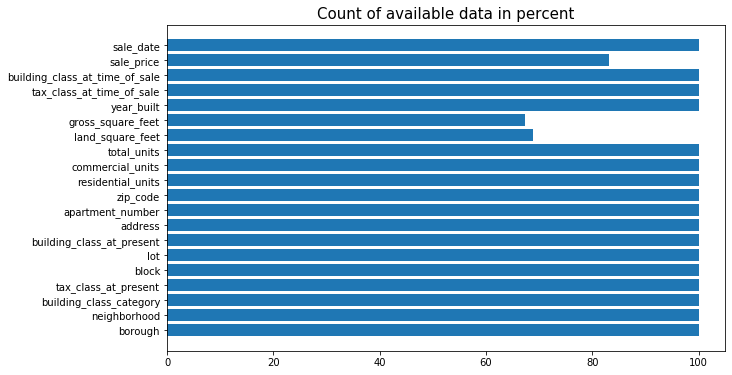

In [176]:
plt.figure(figsize=(10,6))
plt.barh(variables, count_pct)
plt.title('Count of available data in percent', fontsize=15)
plt.show()

In [177]:
## NULL values on Sale Price will be used as TEST
## The rest of the set will be used as train and valid

test = df[df.sale_price.isnull()]
df = df[df.sale_price.notnull()]

In [178]:
df.describe()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_price
count,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,4.844900e+04,4.790000e+04,69607.000000,6.960700e+04
mean,4199.890140,374.580473,10741.159323,1.875070,0.164121,2.059319,3.544802e+03,3.528707e+03,1799.852184,1.280703e+06
std,3431.897518,656.232024,1264.804508,14.291398,8.997236,16.992716,3.973875e+04,2.920564e+04,520.099311,1.143036e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1350.000000,22.000000,10306.000000,0.000000,0.000000,0.000000,1.425000e+03,8.160000e+02,1920.000000,2.300000e+05
50%,3378.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.150000e+03,1.620000e+03,1938.000000,5.330000e+05
75%,6192.000000,820.000000,11249.000000,2.000000,0.000000,2.000000,3.100000e+03,2.508000e+03,1965.000000,9.500000e+05
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


### Observations

1. Min value = 0 on Zip Code
2. Land square feet and gross square feet = 0 (shouldn't be possible)
3. Year Built = 0
4. Sale Price = 0 (transfer property, not sale)

In [179]:
## Get values between 100k and 5kk USD

df = df[(df.sale_price>=100000) & (df.sale_price<=5000000)]
len(df)

54723

In [180]:
df.dropna(inplace=True)

In [181]:
# Keeps properties with fewer than 20,000 Square Feet, which is about 2,000 Square Metres

df = df[df['gross_square_feet'] < 20000]
df = df[df['land_square_feet'] < 20000]

In [182]:
# Units
df = df[(df.total_units>0)&(df.total_units<50)]

In [183]:
#Remove data where commercial + residential doesn't equal total units
df = df[df.total_units == df.commercial_units+df.residential_units]

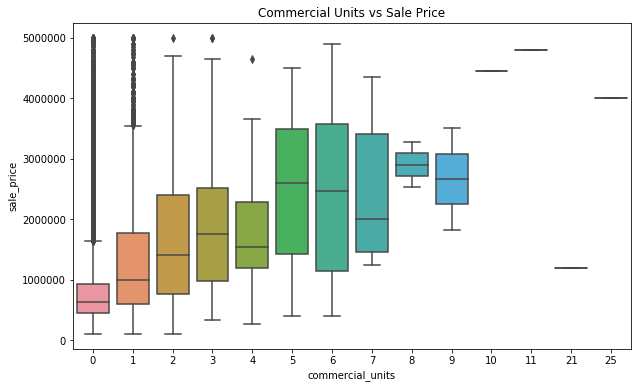

In [184]:
plt.figure(figsize=(10,6))
sns.boxplot(x='commercial_units', y='sale_price', data=df)
plt.title('Commercial Units vs Sale Price')
plt.show()

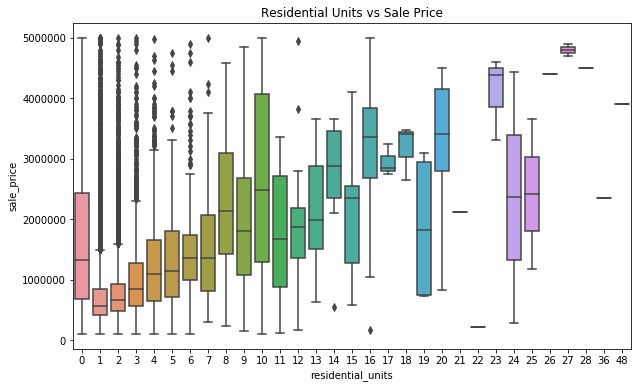

In [185]:
plt.figure(figsize=(10,6))
sns.boxplot(x='residential_units', y='sale_price', data=df)
plt.title('Residential Units vs Sale Price')
plt.show()

In [186]:
## Filter Year = 0

df = df[df.year_built>0]

In [187]:
## Create building age (2017 will be used as current year because the date of dataset)
df['building_age'] = 2017 - df.year_built

Text(0.5, 1.0, 'Sale Price Distribution by Borough')

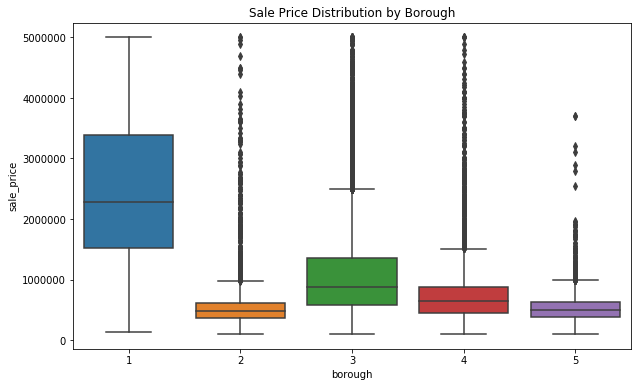

In [188]:
plt.figure(figsize=(10,6))
sns.boxplot(x='borough',y='sale_price',data=df)
plt.title('Sale Price Distribution by Borough')

In [189]:
aux = df[['total_units','gross_square_feet','sale_price','building_age','land_square_feet','residential_units',
          'commercial_units']]
corr = aux.corr()

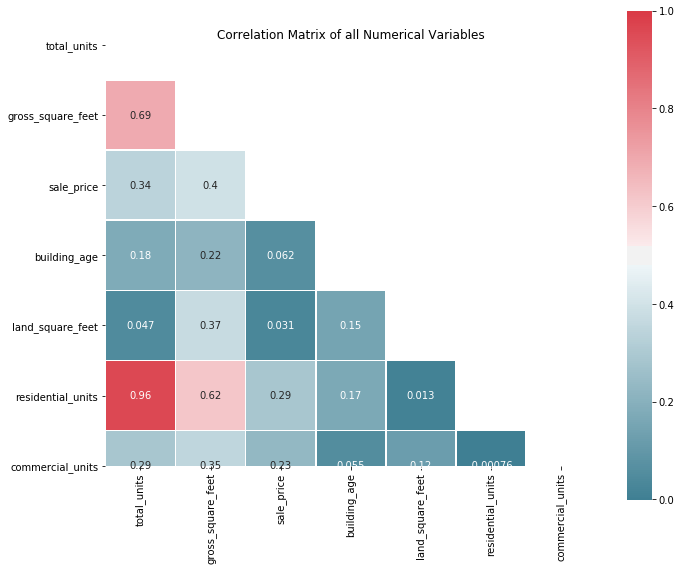

In [190]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=True, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

In [230]:
variables = ['borough','building_class_category','commercial_units','gross_square_feet','sale_price','building_age',
            'land_square_feet','residential_units']
df_model = df.loc[:,variables]

In [231]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29703 entries, 3 to 84545
Data columns (total 8 columns):
borough                    29703 non-null category
building_class_category    29703 non-null object
commercial_units           29703 non-null int64
gross_square_feet          29703 non-null float64
sale_price                 29703 non-null float64
building_age               29703 non-null int64
land_square_feet           29703 non-null float64
residential_units          29703 non-null int64
dtypes: category(1), float64(3), int64(3), object(1)
memory usage: 3.1+ MB


In [232]:
## Get Columns to be One-Hot Encoded
ohe_features = ['building_class_category','borough']

In [233]:
total = 0
for name in ohe_features:
    print('Number of categories',name,':',len(df[name].value_counts()))
    total+=len(df[name].value_counts())
print('Total of new columns with One Hot Encoder:',total)

Number of categories building_class_category : 31
Number of categories borough : 5
Total of new columns with One Hot Encoder: 36


In [234]:
ohe = pd.get_dummies(df_model[ohe_features])
df_model.drop(ohe_features,axis=1,inplace=True)

In [235]:
df_model = pd.concat([df_model,ohe],axis=1)

Text(0.5, 1.0, 'Histogram of Sale Price')

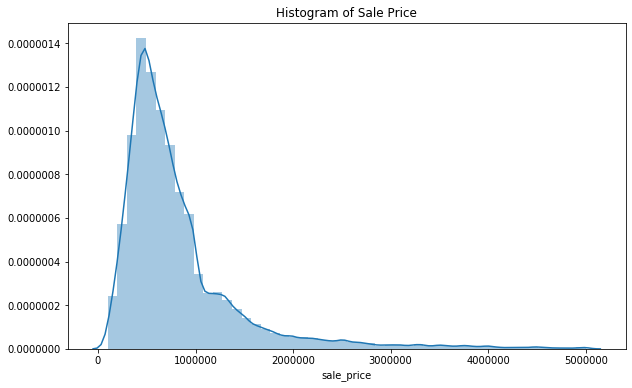

In [236]:
plt.figure(figsize=(10,6))
sns.distplot(df.sale_price)
plt.title('Histogram of Sale Price')

In [237]:
from sklearn.preprocessing import StandardScaler

In [238]:
# Take the log and normalise
df_model['sale_price'] = StandardScaler().fit_transform(np.log(df_model['sale_price']).values.reshape(-1,1))

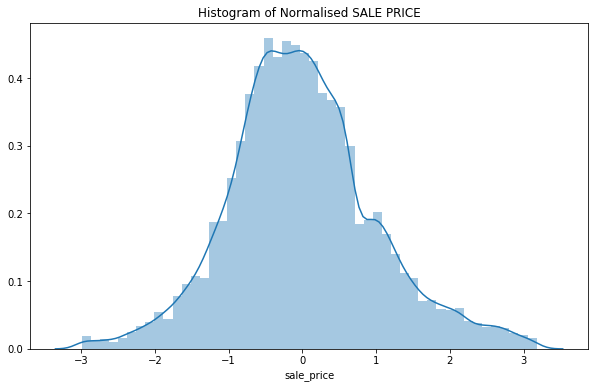

In [239]:
plt.figure(figsize=(10,6))
sns.distplot(df_model.sale_price)
plt.title('Histogram of Normalised SALE PRICE')
plt.show()

**Will add 1 to all unit number because will use log to normalize and 
log(0) isnt defined**

In [240]:
## Add 1 to units
df_model.commercial_units = df_model.commercial_units + 1
df_model.residential_units = df_model.residential_units + 1

In [241]:
## Standardise Units
df_model.commercial_units = StandardScaler().fit_transform(np.log(df_model.commercial_units).values.reshape(-1,1))
df_model.residential_units = StandardScaler().fit_transform(np.log(df_model.residential_units).values.reshape(-1,1))

In [249]:
## Add 1 to square feet
df_model.gross_square_feet = df_model.gross_square_feet + 1
df_model.land_square_feet = df_model.land_square_feet + 1

In [250]:
## Standardise Square Feet
df_model.gross_square_feet = StandardScaler().fit_transform(np.log(df_model.gross_square_feet).values.reshape(-1,1))
df_model.land_square_feet = StandardScaler().fit_transform(np.log(df_model.land_square_feet).values.reshape(-1,1))

In [253]:
## Add 1 to building age
df_model.building_age = df_model.building_age + 1

In [254]:
## Standardise Building Age
df_model.building_age = StandardScaler().fit_transform(np.log(df_model.building_age).values.reshape(-1,1))

### Now the data is standardized we will separate them in train and validation

# 2.0 - Modeling

In [264]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [259]:
Xtrain, Xval, ytrain, yval = train_test_split(df_model.drop('sale_price',axis=1), df_model.sale_price, random_state=0)

In [281]:
mdl0 = RandomForestRegressor()
mdl1 = LGBMRegressor()

In [282]:
mdl0.fit(Xtrain,ytrain)
mdl1.fit(Xtrain,ytrain)

/home/vinicius/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [283]:
p0 = mdl0.predict(Xval)
p1 = mdl1.predict(Xval)

In [284]:
print('RMSE MODEL 0:',np.sqrt(mean_squared_error(p0,yval)))
print('RMSE MODEL 1:',np.sqrt(mean_squared_error(p1,yval)))

RMSE MODEL 0: 0.7895588191227699
RMSE MODEL 1: 0.7308605298786299


**Untunned LGBM has better performance than Random Forest Regressor**